In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/massachusetts-buildings-dataset/label_class_dict.csv
/kaggle/input/massachusetts-buildings-dataset/metadata.csv
/kaggle/input/massachusetts-buildings-dataset/tiff/val_labels/22978945_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/val_labels/23728930_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/val_labels/23429155_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/val_labels/23579050_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/test_labels/23429080_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/test_labels/22829050_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/test_labels/22828990_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/test_labels/24179065_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/test_labels/23579005_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/test_labels/22828930_15.tif
/kaggle/input/massachusetts-buildings-dataset/tiff/test_labels/23578960_15.tif
/kaggle/i

In [30]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as album
import segmentation_models_pytorch as smp

In [31]:
DATA_DIR = '../input/massachusetts-buildings-dataset/tiff/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [32]:
class_dict = pd.read_csv("../input/massachusetts-buildings-dataset/label_class_dict.csv")
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()

In [33]:
select_classes = ['background', 'building']
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values = np.array(class_rgb_values)[select_class_indices]

In [34]:
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20, 8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name.replace('_', ' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map

def reverse_one_hot(image):
    x = np.argmax(image, axis=-1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

In [35]:
class BuildingsDataset(Dataset):
    def __init__(self, images_dir, masks_dir, class_rgb_values=None, augmentation=None, preprocessing=None):
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
    
    def __len__(self):
        return len(self.image_paths)

In [36]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf([
            album.HorizontalFlip(p=1),
            album.VerticalFlip(p=1),
            album.RandomRotate90(p=1),
        ], p=0.75),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0]),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
    return album.Compose(_transform)


In [37]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels - out_channels, in_channels - out_channels, kernel_size=2, stride=2)
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        self.double_conv = DoubleConv(512, 1024)
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [38]:
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [39]:
class HybridLoss(nn.Module):
    def __init__(self):
        super(HybridLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='multiclass')
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        targets = torch.argmax(targets, dim=1)  # Convert one-hot encoded target to class indices
        dice_loss = self.dice_loss(inputs, targets)
        ce_loss = self.ce_loss(inputs, targets.long())
        return dice_loss + ce_loss

# IoU metric
import segmentation_models_pytorch as smp

# Initialize the IoU metric from segmentation_models_pytorch
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

# Function to calculate IoU using smp's IoU metric
def calculate_iou(outputs: torch.Tensor, labels: torch.Tensor):
    # Ensure outputs and labels are on the same device
    outputs, labels = outputs.cpu(), labels.cpu()
    
    # Apply the smp IoU metric
    iou_score = iou_metric(outputs, labels)
    
    # Return the IoU score
    return iou_score.item()



In [40]:
import segmentation_models_pytorch as smp
from tqdm import tqdm

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss function, optimizer, and learning rate scheduler
model = UNet().to(DEVICE)
loss_fn = HybridLoss()
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)

# Define IoU metric with threshold
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

# Function to calculate IoU using smp's IoU metric
def calculate_iou(outputs: torch.Tensor, labels: torch.Tensor):
    # Ensure outputs and labels are on the same device
    outputs, labels = outputs.cpu(), labels.cpu()
    # Apply the smp IoU metric
    iou_score = iou_metric(outputs, labels)
    # Return the IoU score
    return iou_score.item()

# Logging lists
train_logs_list = []
valid_logs_list = []

# Training loop
EPOCHS = 12
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    for images, masks in tqdm(train_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss and IoU for training
        running_loss += loss.item()
        running_iou += calculate_iou(outputs, masks)
    train_loss = running_loss / len(train_loader)
    train_iou = running_iou / len(train_loader)

    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(valid_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            
            # Accumulate loss and IoU for validation
            running_loss += loss.item()
            running_iou += calculate_iou(outputs, masks)
    val_loss = running_loss / len(valid_loader)
    val_iou = running_iou / len(valid_loader)

    # Log results
    train_logs_list.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_iou': train_iou})
    valid_logs_list.append({'epoch': epoch + 1, 'valid_loss': val_loss, 'valid_iou': val_iou})
    
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")
    
    # Update learning rate
    lr_scheduler.step()


Epoch 1/12


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Train Loss: 1.2312, Train IoU: 0.1264
Val Loss: 1.2970, Val IoU: 0.0000
Epoch 2/12


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Train Loss: 1.0833, Train IoU: 0.2491
Val Loss: 1.1875, Val IoU: 0.0001
Epoch 3/12


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Train Loss: 0.9917, Train IoU: 0.3663
Val Loss: 0.9986, Val IoU: 0.1457
Epoch 4/12


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Train Loss: 0.9061, Train IoU: 0.4989
Val Loss: 0.9396, Val IoU: 0.5119
Epoch 5/12


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Train Loss: 0.8574, Train IoU: 0.5515
Val Loss: 0.8808, Val IoU: 0.6373
Epoch 6/12


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Train Loss: 0.8244, Train IoU: 0.5860
Val Loss: 0.7796, Val IoU: 0.6806
Epoch 7/12


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Train Loss: 0.8040, Train IoU: 0.5704
Val Loss: 0.7385, Val IoU: 0.7113
Epoch 8/12


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Train Loss: 0.7853, Train IoU: 0.5869
Val Loss: 0.7010, Val IoU: 0.7689
Epoch 9/12


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Train Loss: 0.7465, Train IoU: 0.6167
Val Loss: 0.7151, Val IoU: 0.7526
Epoch 10/12


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Train Loss: 0.7495, Train IoU: 0.6259
Val Loss: 0.6595, Val IoU: 0.7573
Epoch 11/12


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Train Loss: 0.7333, Train IoU: 0.6354
Val Loss: 0.6725, Val IoU: 0.7423
Epoch 12/12


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

Train Loss: 0.7133, Train IoU: 0.6749
Val Loss: 0.6831, Val IoU: 0.7502


In [41]:
# Define test dataset and dataloader
test_dataset = BuildingsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# Function to evaluate model on test data
def evaluate_model(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            running_loss += loss.item()
            running_iou += calculate_iou(outputs, masks)  # Using smp's IoU metric with threshold
    epoch_loss = running_loss / len(dataloader)
    epoch_iou = running_iou / len(dataloader)
    return epoch_loss, epoch_iou

# Evaluate model on test data
test_loss, test_iou = evaluate_model(model, test_dataloader, loss_fn, DEVICE)
print(f"Evaluation on Test Data: Mean IoU Score: {test_iou:.4f}, Mean Dice Loss: {test_loss:.4f}")


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]

Evaluation on Test Data: Mean IoU Score: 0.6658, Mean Dice Loss: 0.6948


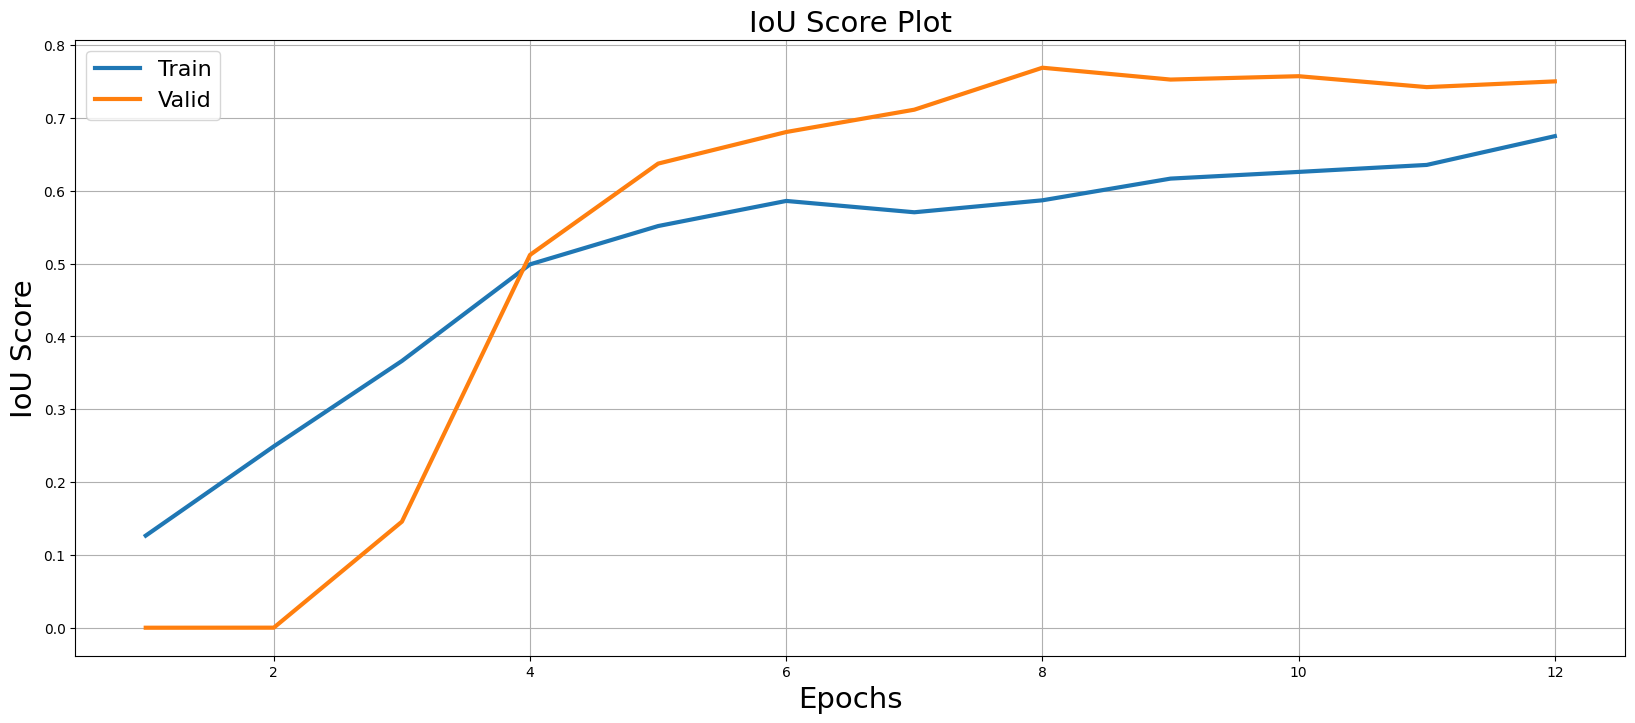

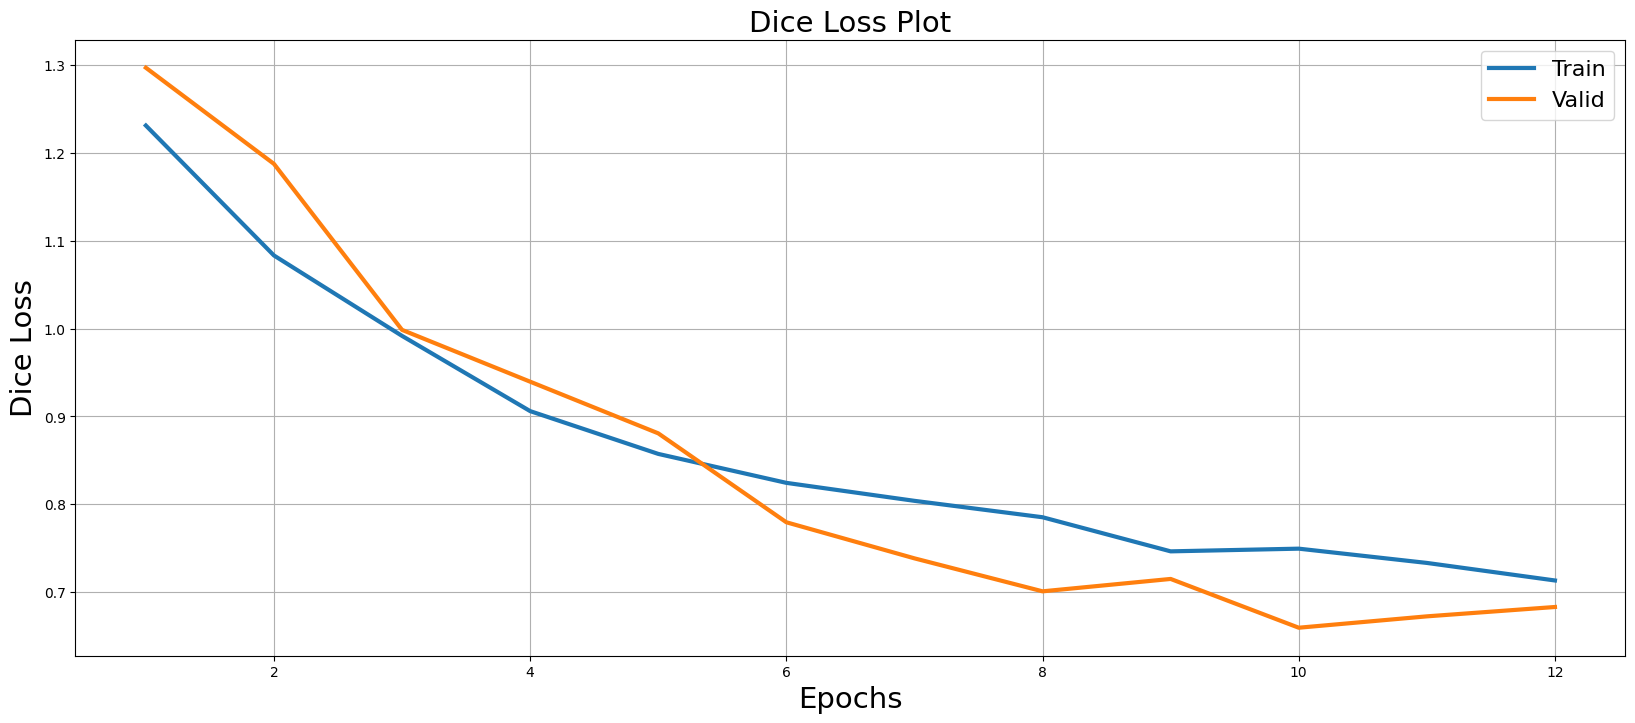

In [42]:
# Visualization of metrics
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)

plt.figure(figsize=(20, 8))
plt.plot(train_logs_df['epoch'], train_logs_df['train_iou'], lw=3, label='Train')
plt.plot(valid_logs_df['epoch'], valid_logs_df['valid_iou'], lw=3, label='Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(train_logs_df['epoch'], train_logs_df['train_loss'], lw=3, label='Train')
plt.plot(valid_logs_df['epoch'], valid_logs_df['valid_loss'], lw=3, label='Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

In [43]:
def save_predictions(model, dataloader, device, class_rgb_values, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(dataloader, desc="Saving Predictions")):
            images = images.to(device)
            outputs = model(images)
            predicted_masks = outputs.cpu().numpy()
            
            # Convert predictions to RGB format
            predicted_masks = np.argmax(predicted_masks, axis=1)
            decoded_preds = [colour_code_segmentation(mask, class_rgb_values) for mask in predicted_masks]
            
            for j, decoded_pred in enumerate(decoded_preds):
                # Convert to uint8 format
                decoded_pred = decoded_pred.astype(np.uint8)
                
                # Save each prediction as an image
                save_path = os.path.join(save_dir, f'pred_{i * len(decoded_preds) + j}.png')
                cv2.imwrite(save_path, cv2.cvtColor(decoded_pred, cv2.COLOR_RGB2BGR))

# Specify the directory for saving predictions
predictions_dir = './predictions'
save_predictions(model, test_dataloader, DEVICE, select_class_rgb_values, predictions_dir)


Saving Predictions: 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]
